In [1]:
# Translation example with recurrent neural networks 

import tensorflow as tf
import numpy as np 
import os 

SEED = 1234

working_directory = os.getcwd()

tf.random.set_seed(SEED)
np.random.seed(SEED)

In [2]:
from google.colab import drive
drive.mount(os.path.join(working_directory,'gdrive'))

Mounted at /content/gdrive


In [3]:
!ls gdrive/MyDrive

'Colab Notebooks'		    mixedtree.c
'DD document.gdoc'		    output_submission
'DD to be analyzed.gdoc'	   'RASD document.gdoc'
'Documento senza titolo (1).gdoc'   Relation1_AN2DL.gdoc
'Documento senza titolo.gdoc'	    Relation_GrottaNatta_H2.gdoc
 ita.txt			   'Research project notes.gdoc'
 Keras3				   'Transaction control DB2.gdoc'
 MaskDataset			    UCMerced_LandUse.zip
 MaskDataset.zip		    VOCDataset.zip


In [4]:
dataset_path = os.path.join(working_directory,'gdrive','MyDrive','ita.txt')

# **Dataset**

In [5]:
# preparing dataset 

MAX_NUM_SENTENCES = 40000
MAX_NUM_WORDS = 20000

ita_sentences = []
eng_sentences = []
eng_sentences_train = []

# Simplify the dataset
MAX_LEN = 3 # maximum length of a sentence

# Read all lines in translation dataset
count = 0
for line in open(dataset_path, encoding='utf-8'):
    
    if count > MAX_NUM_SENTENCES:
        break

    if '\t' not in line:
        continue
        
    eng_sentence_, ita_sentence, _ = line.rstrip().split('\t') # eng and ita sentence are separated by a tab

    if (len(eng_sentence_.split(' ')) > MAX_LEN or
          len(ita_sentence.split(' ')) > MAX_LEN):
      continue
    
    # using teacher forcing training -> using output as input in sequence prediction 
    # each LSTM has 2 inputs (one for the previous state and one free)
    # for the decoder part of the seq2seq model I have the input of the previous state
    # and the previous target word (t-1). We use the previous target word as input
    # and we compare the final output of that single LSTM with the target word of t 
    # Prepend <SOS> to the target_sequence to obtain the target_input_sequence and
    # append <EOS> to obtain target_output_sequence .
    
    # target output of the decoder
    eng_sentence = eng_sentence_ + ' <eos>'
    # input of the decoder
    eng_sentence_train = '<sos> ' + eng_sentence_
    
    ita_sentences.append(ita_sentence)
    eng_sentences.append(eng_sentence)
    eng_sentences_train.append(eng_sentence_train)

    count += 1

print('Number of sentences:', len(ita_sentences))


Number of sentences: 32499


In [6]:
# max number of words in eng_sentences (eng sentences with '<eos>' appended)
max(len(sentence.split(' ')) for sentence in eng_sentences)

4

# **Tokenization**: converting word to integers

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# LSTMs work with integers and not strings 

# Create Tokenizer to convert words to integers
ita_tokenizer = Tokenizer(num_words= MAX_NUM_WORDS) #length of the vocabulary 
ita_tokenizer.fit_on_texts(ita_sentences)

# ita_tokenized is the list of ita sentences converted to sequences of integers
ita_tokenized = ita_tokenizer.texts_to_sequences(ita_sentences)

# ita_wtoi is a dictionary mapping words to the integer associated thanks to tokenizer
ita_wtoi = ita_tokenizer.word_index
print('Total italian words:', len(ita_wtoi))

max_ita_length = max(len(sentence) for sentence in ita_tokenized)
print('Max italian sentence length:', max_ita_length)

# tokenization of both eng_sentences list ('+' is the union of strings)
eng_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='?!,."')
eng_tokenizer.fit_on_texts(eng_sentences+eng_sentences_train)

# converting the 2 lists
eng_tokenized = eng_tokenizer.texts_to_sequences(eng_sentences)
eng_tokenized_train = eng_tokenizer.texts_to_sequences(eng_sentences_train)

eng_wtoi = eng_tokenizer.word_index
print('Total english words:', len(eng_wtoi))

max_eng_length = max(len(sentence) for sentence in eng_tokenized)
print('Max english sentence length:', max_eng_length)

num_eng_words = len(eng_wtoi) + 1

Total italian words: 8524
Max italian sentence length: 4
Total english words: 3858
Max english sentence length: 4


In [8]:
# Padding sequences

# <PAD> is 0 in the wtoi dictionary 
# post padding  ->  aaaa0..0 
# pre padding   ->  0..0aaaa 

# Pad to max italian sentence length
ita_encoder_inputs = pad_sequences(ita_tokenized, maxlen=max_ita_length) # padding automatically set to pre

print("Italian encoder inputs shape:", ita_encoder_inputs.shape)

# Pad to max english sentence length
eng_decoder_inputs = pad_sequences(eng_tokenized_train, maxlen=max_eng_length, padding='post')

print("English decoder inputs shape:", eng_decoder_inputs.shape)

# Pad to max english sentence length
eng_outputs = pad_sequences(eng_tokenized, maxlen=max_eng_length, padding='post')

Italian encoder inputs shape: (32499, 4)
English decoder inputs shape: (32499, 4)


In [9]:
print(len(ita_wtoi))

8524


# **Model**



# Single cell of a LSTM
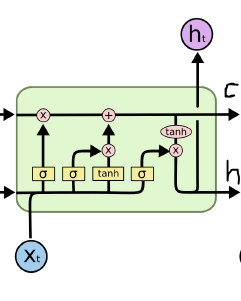

In [10]:
# Build Encoder-Decoder Model
# ---------------------------

EMBEDDING_SIZE = 32

# ENCODER
# -------
# in keras out = layer(input)

encoder_input = tf.keras.Input(shape=[max_ita_length])

# Embedding layer: Turns positive integers (indexes) into dense vectors of fixed size.
# I will have 8524 integers that will be embedded in 32 
# If mask_zero is set to True, as a consequence, index 0 cannot be used in the 
# vocabulary (input_dim should equal size of vocabulary + 1). 
# in ita_wtoi I don't have {0: padding} but it's implicit and integers starts from 1
# mask_zero takes the 0 and cut it out 
encoder_embedding_layer = tf.keras.layers.Embedding(len(ita_wtoi)+1, EMBEDDING_SIZE, input_length=max_ita_length, mask_zero=True)
encoder_embedding_out = encoder_embedding_layer(encoder_input)

# I need 128 units because I have 4 words each embedded in 32 integers values (128 lstm cells)
encoder = tf.keras.layers.LSTM(units=128, return_state=True)

encoder_output, h, c = encoder(encoder_embedding_out)
encoder_states = [h, c]

# DECODER
# -------

# same as the encoder
decoder_input = tf.keras.Input(shape=[max_eng_length])
decoder_embedding_layer = tf.keras.layers.Embedding(len(eng_wtoi)+1, EMBEDDING_SIZE)
decoder_embedding_out = decoder_embedding_layer(decoder_input)

# return_sequences = True -> return each output 
decoder_lstm = tf.keras.layers.LSTM(units=128, return_sequences=True, return_state=True)

# Initialize decoder state with final returned encoder state [h,c] (initial_state=encoder_states)
decoder_lstm_out, _, _ = decoder_lstm(decoder_embedding_out, initial_state=encoder_states)

# the decoder output is a sequence of integers that needs to be decoded with a dense layer.
# remember that each of the 128 units of the decoder outputs a number that is part of the embedding (32) of a single word. 32 numbers of those should activate the 
# n-th neuron of the dense layer which corresponds to the assigned integer in the wtoi dictionary of the word (embedded in those 32 numbers).
decoder_dense = tf.keras.layers.Dense(len(eng_wtoi)+1, activation='softmax')
decoder = decoder_dense(decoder_lstm_out)

# MODEL
model = tf.keras.Model([encoder_input, decoder_input], decoder)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 4, 32)        272800      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 4, 32)        123488      input_2[0][0]                    
______________________________________________________________________________________________

In [16]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy()

# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

checkpoint_dir = os.path.join(working_directory,'ckpts')

if not os.path.exists(checkpoint_dir):
  os.mkdir(checkpoint_dir)

callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_dir, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto'
)]


In [17]:
model.fit([ita_encoder_inputs, eng_decoder_inputs],
          eng_outputs,
          epochs=25,
          batch_size=128, 
          validation_split=0.1, 
          callbacks=callbacks)

Epoch 1/25
229/229 [==============================] - 11s 30ms/step - loss: 0.5425 - accuracy: 0.8784 - val_loss: 3.7670 - val_accuracy: 0.5435
Epoch 2/25
229/229 [==============================] - 5s 24ms/step - loss: 0.5006 - accuracy: 0.8902 - val_loss: 3.7758 - val_accuracy: 0.5485
Epoch 3/25
229/229 [==============================] - 6s 24ms/step - loss: 0.4610 - accuracy: 0.8966 - val_loss: 3.8104 - val_accuracy: 0.5504
Epoch 4/25
229/229 [==============================] - 6s 25ms/step - loss: 0.4208 - accuracy: 0.9041 - val_loss: 3.8365 - val_accuracy: 0.5524
Epoch 5/25
229/229 [==============================] - 6s 24ms/step - loss: 0.3898 - accuracy: 0.9086 - val_loss: 3.8633 - val_accuracy: 0.5541
Epoch 6/25
229/229 [==============================] - 6s 25ms/step - loss: 0.3630 - accuracy: 0.9139 - val_loss: 3.9031 - val_accuracy: 0.5528
Epoch 7/25
229/229 [==============================] - 6s 24ms/step - loss: 0.3395 - accuracy: 0.9180 - val_loss: 3.9343 - val_accuracy: 0.552

# **Model to use for predicitons:**

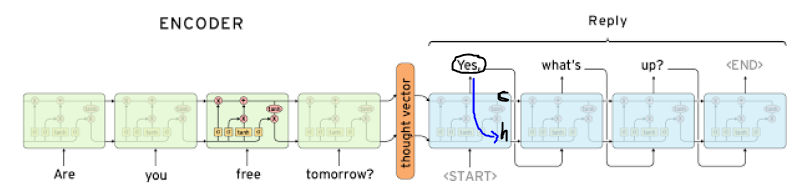

In [20]:
# Uncomment this to load model

# Modify the model such that the decoder takes prdictions as inputs (no teacher forcing)

# ENCODER (remains the same)
# -------
encoder_model = tf.keras.Model(encoder_input, encoder_states)

# DECODER (modified)
# ------------------
decoder_state_input_h = tf.keras.Input(shape=[128])
decoder_state_input_c = tf.keras.Input(shape=[128])
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]

# I only have a single input for the decoder -> start
# other inputs are taken from the states of the previous sequence  
decoder_input_single = tf.keras.Input(shape=[1])
decoder_input_single_embedding = decoder_embedding_layer(decoder_input_single)


decoder_outputs, h, c = decoder_lstm(decoder_input_single_embedding, initial_state=decoder_state_inputs)

decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = tf.keras.Model([decoder_input_single] + decoder_state_inputs,
                               [decoder_outputs]+decoder_states)



In [21]:
# Translation utils
ita_itow = {v:k for k, v in ita_wtoi.items()}
eng_itow = {v:k for k, v in eng_wtoi.items()}

def translate(input_sentence):
    
    # Prepare input sentence
    input_tokenized = ita_tokenizer.texts_to_sequences([input_sentence])
    input_tokenized = pad_sequences(input_tokenized, maxlen=max_ita_length)
    
    # Get encoder state
    states_value = encoder_model.predict(input_tokenized)
    
    # Set first input '<sos>'
    curr_input = np.zeros([1, 1])  # bs x seq_length (1 x 1 at the beginning)
    curr_input[0, 0] = eng_wtoi['<sos>']
    eos = eng_wtoi['<eos>']
    
    output_sentence = []
    
    # Cycle until max_eng_length or until the '<eos>' is predicted
    for _ in range(max_eng_length):
        preds, h_, c_ = decoder_model.predict([curr_input]+states_value)
        word_id = np.argmax(preds[0, 0, :])
        
        if eos == word_id:
            break
        
        word = ''
        
        if word_id > 0:
            word = eng_itow[word_id]
            output_sentence.append(word)
            
        # Update next input with the predicted one
        curr_input[0, 0] = word_id
        # Update state
        states_value = [h_, c_]
    
    return ' '.join(output_sentence)

In [31]:
print(translate("Bel piccione"))

forget that


i fell lying


fight you
